In [1]:
from sklearn.datasets import fetch_openml
import torch
import numpy as np

In [2]:
# Download & Preprocess Dataset 
mnist= fetch_openml('mnist_784')

# Set GPU Device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# Set the first 60,000 out of 70,000 as Train data
X_train = torch.tensor(np.array(mnist.data)).float().reshape(-1, 1, 28, 28)[:60000].to(device)
Y_train = torch.tensor(np.array(list(map(np.int_, mnist.target))))[:60000].to(device)

# Set the last 10,000 out of 70,000 as Test data
X_test = torch.tensor(np.array(mnist.data)).float().reshape(-1, 1 ,28, 28)[60000:].to(device)
Y_test = torch.tensor(np.array(list(map(np.int_, mnist.target))))[60000:].to(device)

print(X_train.shape) # torch.Size([60000, 1, 28, 28])
print(Y_train.shape) # torch.Size([60000])

print(X_test.shape) # torch.Size([10000, 1, 28, 28])
print(Y_test.shape) # torch.Size([10000])

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


C:\Users\isang\AppData\Local\Temp\ipykernel_42384\997699111.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  original = np.array(img_example).reshape(-1, 28).astype(int)
C:\Users\isang\AppData\Local\Temp\ipykernel_42384\997699111.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  aug_img = np.array(cutout_and_rotate(img_example)).reshape(-1, 28).astype(int)


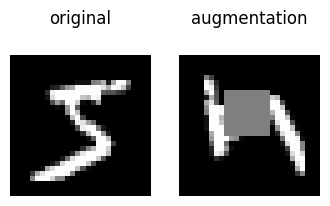

In [3]:
# Data Augmentation
def cutout_and_rotate(image):
    image = image.clone().detach() 
    x_start = np.random.randint(20)     # Cut- out x-axis position to start (1 of 0-19)
    y_start = np.random.randint(20)     # Cut- out y-axis position to start (1 of 0-19)

    # Gray marking on the corresponding part
    image[..., x_start:x_start+9, y_start:y_start+9] = 255/2
    # 90 degree rotation based on the last two axis
    return torch.rot90(image, 1, [-2, -1])

# Test Case fot Data Augmentation
import matplotlib.pyplot as plt
from matplotlib.pyplot import style

# Specify whit background & its size  
style.use('default')
figure = plt.figure()
figure.set_size_inches(4, 2)

# Set the style for black & white print
style.use('grayscale')

# 1x2 size grid setting
axes = []
for i in range(1,3):
    axes.append(figure.add_subplot(1, 2, i))

# Visulization of the original Image
# Visulization of the image performed by augmentation fot the first image
img_example = X_train[0].clone().detach().cpu()
original = np.array(img_example).reshape(-1, 28).astype(int)
aug_img = np.array(cutout_and_rotate(img_example)).reshape(-1, 28).astype(int)

axes[0].matshow(original)
axes[1].matshow(aug_img)

axes[0].set_axis_off()
axes[0].set_title('original')
axes[1].set_axis_off() 
axes[1].set_title('augmentation')

plt.show()

In [4]:
# Implementing CNN Model Structure
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride= 1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride= 1)
        self.fc = nn.Linear(4 * 4 * 20, 100)

    def forward(self, x):
        # (batch, 1, 28, 28) -> (batch, 10, 24, 24)
        x = F.relu(self.conv1(x)) 
        # (batch, 10, 24, 24) -> (batch, 10, 12, 12)
        x = F.max_pool2d(x, kernel_size=2, stride=2) 
        # (batch, 10, 12, 12) -> (batch, 20, 8, 8)
        x = F.relu(self.conv2(x)) 
        # (batch, 20, 8, 8) -> (batch, 20, 4, 4)
        x = F.max_pool2d(x, kernel_size=2, stride=2) 
        # (batch, 20, 4, 4) -> (batch, 320)
        x = x.view(-1, 4 * 4 * 20) 
        # (batch, 320) -> (batch, 100)
        x = F.relu(self.fc(x)) 
        # (batch, 100)
        return x 

In [5]:
# Implementing Loss Function
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    # masking matrix to import only the internal sum
        # between the negative samples of the loss denominator part
    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        # The source of the loss molecule part
        # The part to get the internal sum between the augmentation images
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [6]:
# Pre-train
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# Augmentation for each X_train data
X_train_aug = cutout_and_rotate(X_train) 
# Declare to GPU for Learning
X_train_aug = X_train_aug.to(device) 

# Pair with Augmentation data
dataset = TensorDataset(X_train, X_train_aug) 
batch_size = 32

dataloader = DataLoader(
            dataset,
            batch_size = batch_size)

# Declare Model variable
model = CNN() 
# Declare Loss Function
loss_func = SimCLR_Loss(batch_size, temperature = 0.5) 

# training
epochs = 10
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(1, epochs + 1):
    total_loss = 0
    for data in tqdm(dataloader):
        origin_vec = model(data[0])
        aug_vec = model(data[1])

        loss = loss_func(origin_vec, aug_vec)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / len(dataloader)))

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 1, Avg Loss : 3.0187


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 2, Avg Loss : 2.7996


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 3, Avg Loss : 2.7614


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 4, Avg Loss : 2.7169


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 5, Avg Loss : 2.6954


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 6, Avg Loss : 2.6813


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 7, Avg Loss : 2.6652


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 8, Avg Loss : 2.6564


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 9, Avg Loss : 2.6507


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 10, Avg Loss : 2.6429


In [ ]:
# Downstream model for Classification
class CNN_classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        # Load model trained with Constrastive Learning
        self.CNN = model 
        # Projection by the number of class dimensions
        self.mlp = nn.Linear(100, 10) 

    def forward(self, x):
        x = self.CNN(x) # Convert to (batch, 100)
        x = self.mlp(x) # Convert to (batch, 10)
        return x # (batch, 10)

# Pair with Data & Lable
class_dataset = TensorDataset(X_train, Y_train)
batch_size = 32

class_dataloader = DataLoader(
        class_dataset,
        batch_size = batch_size)


# Classification Downstream model Training
classifier = CNN_classifier(model).to(device)
classifier_loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(classifier.parameters(), lr= 1e-4)

for i in range(1, epochs + 1):
    correct = 0
    for data in tqdm(class_dataloader):
        logits = classifier(data[0])

        loss = classifier_loss(logits, data[1].long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate number of correct answers for Accuracy calculation
        correct += torch.sum(torch.argmax(logits, 1) == data[1]).item() 

    print('Epoch : %d, Train Accuracy : %.2f%%'%(i, correct * 100 / len(X_train)))

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 1, Train Accuracy : 69.58%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 2, Train Accuracy : 93.64%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 3, Train Accuracy : 95.92%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 4, Train Accuracy : 96.86%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 5, Train Accuracy : 97.40%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 6, Train Accuracy : 97.78%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 7, Train Accuracy : 98.09%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 8, Train Accuracy : 98.31%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 9, Train Accuracy : 98.48%


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch : 10, Train Accuracy : 98.61%


In [9]:
# Verification with Test Data
# pair with Test data & Label
test_dataset = TensorDataset(X_test, Y_test) 
batch_size = 32

test_dataloader = DataLoader(
            test_dataset,
            batch_size = batch_size)

# Convert to Test mode
classifier.eval() 

correct = 0
for data in tqdm(test_dataloader):

    logits = classifier(data[0])
    # Accumulate number of correct answers for Accuracy calculation
    correct += torch.sum(torch.argmax(logits, 1) == data[1]).item() 

print('Test Accuracy : %.2f%%'%(correct * 100 / len(X_test)))

  0%|          | 0/313 [00:00<?, ?it/s]

Test Accuracy : 98.31%
